# MCMC Sampling

Markov chain monte Carlo Sampling

*Quickly* sample from any distribution.

## Advantages:
* Works with unnormalized denisty.
* Faster than other sampling methods (ex: rejection sampling)
* Easier to work with compared to rejction sampling (we had to choose appropriate g(x))

Let's suppose we wanted to sample from the density f(x). 

One method that we learnt is rejection sampling.

Recall the condition for rejection.


But we know, that if we got a point of high probability at a location, the points near it will also have a fair chance of having high probability.

In order to use this fact, we will 'engineer' a markov chain which has the stationary distribution $f(x)$.

An algorithm is the Metropolis Hastings algorithm which engineers such markov chains.


what is support?

The algorithm is following:

Start with initial point as some $x_i$ in the support of the $f(x)$.

Sample a proposal point $a$ from a distribution $g(X_{i+1}| X_i)$

accept the proposal with probability 
\begin{equation}
p = min(1, \frac{f(a)}{f(x_i)})
\end{equation}

i.e, 

if the proposal is accepted, set $x_{i+1} = a$

$x_{i+1} = x_{i}$ otherwise.

given that $g(X_{i+1}|X_i)$ satisfies some properties.

Ex: we should be able to go to every location starting from any location. etc.

one of the distribution that satisfies all these conditions is
\begin{equation}
g(X_{i+1}|X_i) = N(X_i,\sigma_{prop})
\end{equation}

If we use this as our proposal distribution, it is called *Random walk Metropolis-Hastings (RMH) algorithm*

Suppose we want to sample from a distribution that looks like this

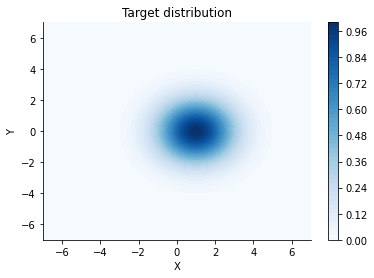


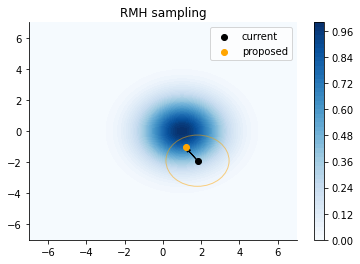

Start with some initial point $X_i$ and sample a point $a$ from $N(X_i,\sigma)$. If it is uphill, accept it. 


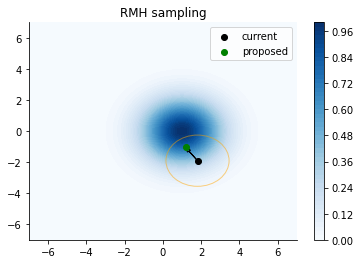

If it is going downhill, it is accepted with probability $\frac{f(a)}{f(x_i}$

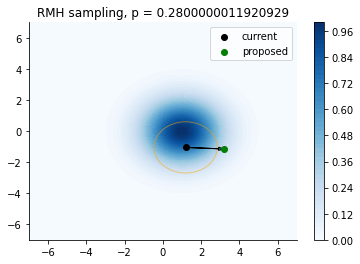

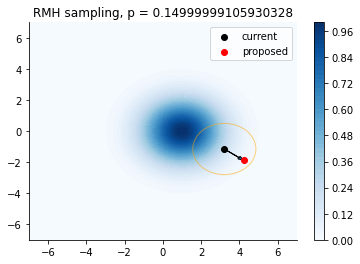

# Code

In [3]:
import jax.numpy as jnp
import jax
import tensorflow_probability.substrates.jax as tfp
from rmh import plot_rmh

tfd = tfp.distributions

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse

import blackjax

In [2]:
mu = jnp.array([[1.,0]])
sigma = jnp.array([[2.,0],[0,2.0]])

# Un-normailized  2-D Normal distribution.
def log_target(x):
    # use tfd here.
    # return (-(1/2)*((x-mu)@jnp.linalg.inv(sigma))@(x-mu).T)[0][0].astype(jnp.float32)
    norm = tfd.MultivariateNormalFullCovariance(mu,sigma)
    return norm.log_prob(x)[0]

In [4]:
x = jnp.linspace(-7,7,50)
y = jnp.linspace(-7,7,50)
XX, YY = jnp.meshgrid(x,y)
likel = []
for i in range(XX.shape[0]):
    prob = []
    for j in range(XX.shape[1]):
        prob.append(jnp.exp(log_target(
            jnp.array([XX[i][j],YY[i][j]])
            )))
    likel.append(prob)

likel = jnp.array(likel)

KeyboardInterrupt: 

In [8]:
norm = tfd.MultivariateNormalFullCovariance(mu,sigma)
grid = jax.tree_map(lambda x,y: jnp.array([x,y]),XX,YY)
likel = jnp.exp(norm.prob(grid.T).T)

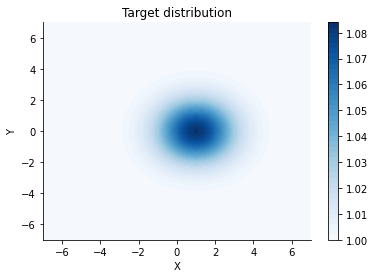

In [9]:
fig, ax = plt.subplots(1, 1)
cs = ax.contourf(XX,YY,likel,50,cmap="Blues")
plt.xlabel("X")
plt.ylabel("Y")
sns.despine()
ax.set_title("Target distribution")
fig.colorbar(cs,ax = ax)

In [18]:
norm = tfd.Normal(mu,1)
norm.prob(jnp.array([2.0,0.0])).prod()
# norm

DeviceArray(0.09653236, dtype=float32)

In [21]:
sigma = jnp.identity(2)
multi_norm = tfd.MultivariateNormalFullCovariance(mu,sigma)
multi_norm.prob(jnp.array([[2.0,0.0]]))

DeviceArray([0.09653236], dtype=float32)

# The algorithm

In [22]:
samples = [jnp.array([-3.,-3])]
num_accept = 0
num_samples = 1000
seed = jax.random.PRNGKey(1)
prop_width = 1.0
for _ in range(num_samples):
    
    #sample candidate from normal distribution
    proposal = tfd.Normal(samples[-1], prop_width)
    candidate = proposal.sample(seed= seed)
    seed, _ = jax.random.split(seed)
    
    #calculate probability of accepting this candidate
    prob = min(1, jnp.exp(log_target(candidate)) / jnp.exp(log_target(samples[-1])))
    
    #accept with the calculated probability
    if jax.random.uniform(seed) < prob:
        samples.append(candidate)
        num_accept += 1
    
    #otherwise report current sample again
    else:
        samples.append(samples[-1])

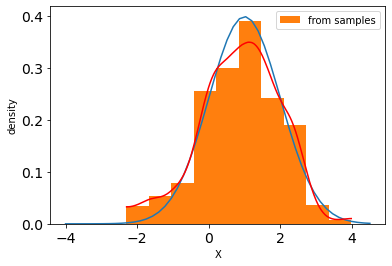

In [24]:
import arviz as az

samples = jnp.array(samples)
burnin = 300
# show marginalized distribution here.
normal_marginalized = tfd.Normal(mu[0,0],jnp.sqrt(sigma[0,0]))
x_lin = jnp.linspace(-4,4.5)
plt.plot(x_lin,normal_marginalized.prob(x_lin))
plt.hist(samples[burnin:,0],density=True,label="from samples")
az.plot_dist(samples[burnin:,0],color="red")
plt.xlabel("X")
plt.ylabel("density")
plt.legend()

## Using blackjax's rmh

In [25]:
prop_width = jnp.array([1.,1.0])
# we are sampling 2 variables here, so the length of array prop
# width should be 2

rmh = blackjax.rmh(log_target, sigma= prop_width)
initial = jnp.array([[-3.0,-3]])
initial_state = rmh.init(initial)

In [26]:
initial_state

RMHState(position=DeviceArray([[-3., -3.]], dtype=float32), log_probability=DeviceArray(-14.337877, dtype=float32))

In [30]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state,info)
    
    keys = jax.random.split(rng_key, num_samples)
    _, info = jax.lax.scan(one_step, initial_state, keys)
    return info

In [34]:
rng_key = jax.random.PRNGKey(0)
num_samples = 1000
states,infos = inference_loop(rng_key, rmh.step, initial_state, num_samples)

(-6.0, 6.0)

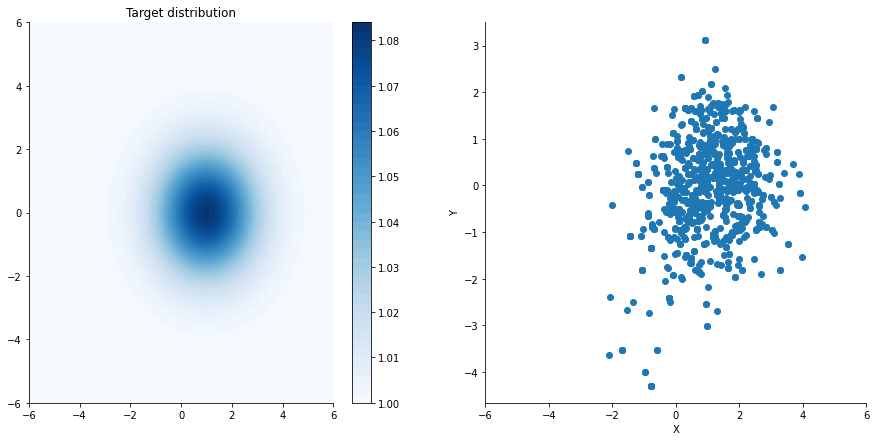

In [35]:
fig, (ax,ax1) = plt.subplots(1, 2,figsize=(15,7))
cs = ax.contourf(XX,YY,likel,50,cmap="Blues")
plt.xlabel("X")
plt.ylabel("Y")
sns.despine()
ax.set_title("Target distribution")
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)

fig.colorbar(cs,ax = ax)
ax1.scatter(states.position[:,:,0].reshape(-1),states.position[:,:,1].reshape(-1))
ax1.set_xlim(-6,6)
ax.set_ylim(-6,6)

In [24]:
infos.is_accepted.sum()/num_samples

DeviceArray(0.666, dtype=float32)

In [28]:
def plot_rmh(states,burnin):
    for i in range(states.position.shape[2]):
    
        fig, (ax,ax1) = plt.subplots(1,2,figsize=(8,3))
        ax.plot(states.position[:,:,i])
        ax.set_title('trace plot')
        ax.axvline(x=burnin, c="tab:red")
        ax1.hist(states.position[burnin:,:,i].reshape(-1),density=True)
        sns.kdeplot(states.position[burnin:,:,i].reshape(-1),ax=ax1)
        ax1.set_title("histogram")
        plt.suptitle(str(i),fontsize=20)
        try:
            plt.savefig('figures/'+str(i)+'.jpeg')
        except:
            os.mkdir('figures')
            plt.savefig('figures/'+str(i)+'.jpeg')
        plt.show()



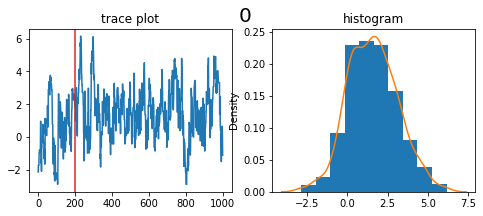

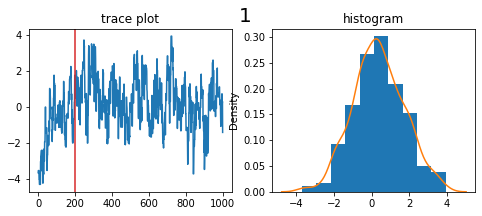

In [27]:
plot_rmh(states,200)

In [29]:
proposal_width = jnp.array([0.1,0.1])
num_samples = 1000
rmh = blackjax.rmh(dist_numerator, sigma= proposal_width)
initial = jnp.array([[-3.0,-3]])
initial_state = rmh.init(initial)

states_low_sigma,infos_low_sigma = inference_loop(rng_key, rmh.step, initial_state, num_samples)

In [30]:
print("fraction acceptance")
infos_low_sigma.is_accepted.sum()/num_samples

fraction acceptance


DeviceArray(0.96, dtype=float32)

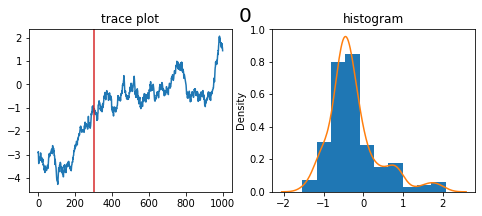

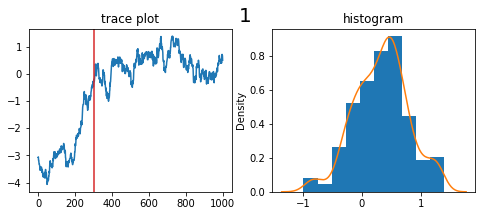

In [32]:
plot_rmh(states_low_sigma,burnin=300)

In [33]:
proposal_width = jnp.array([10,10])
num_samples = 1000
rmh = blackjax.rmh(dist_numerator, sigma= proposal_width)
initial = jnp.array([[-3.0,-3]])
initial_state = rmh.init(initial)

states_high_sigma,infos_high_sigma = inference_loop(rng_key, rmh.step, initial_state, num_samples)

In [34]:
infos_high_sigma.is_accepted.sum()/num_samples

DeviceArray(0.048, dtype=float32)

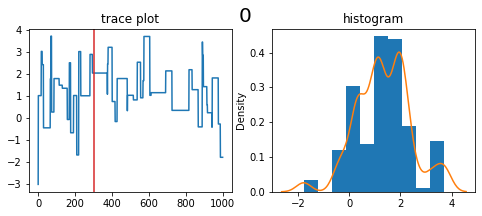

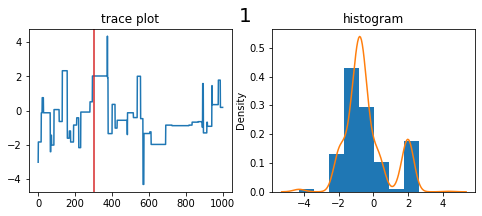

In [35]:
plot_rmh(states_high_sigma,300)

In [18]:
x = jnp.linspace(-7,7,50)
y = jnp.linspace(-7,7,50)
XX, YY = jnp.meshgrid(x,y)
likel = []
for i in range(XX.shape[0]):
    prob = []
    for j in range(XX.shape[1]):
        prob.append(jnp.exp(log_target(
            jnp.array([XX[i][j],YY[i][j]])
            )))
    likel.append(prob)

likel = jnp.array(likel)


In [77]:
grid = jax.tree_map(lambda x,y: (jnp.array([[x,y]])), XX, YY).reshape(2,XX.shape[0],XX.shape[1])
normal = tfd.MultivariateNormalFullCovariance(mu.astype(jnp.float32),jnp.sqrt(sigma))

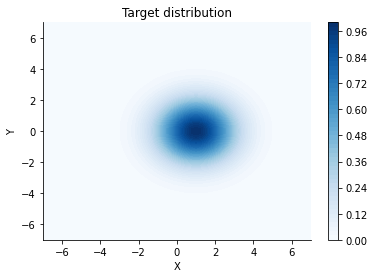

In [26]:
color = {True:"green",False:"red"}

In [63]:
!mkdir figures_prob

In [64]:
for i in range(100):
    x_cur = states.position[i-1,0,0]
    y_cur = states.position[i-1,0,1]
    x_prop = infos.proposal[0][i,0,0]
    y_prop = infos.proposal[0][i,0,1]
    fig, ax = plt.subplots(1, 1)
    cs = ax.contourf(XX,YY,likel,50,cmap="Blues")
    ax.scatter(x_cur,y_cur,c='black',label='current')
    ell = Ellipse( (x_cur, y_cur ),
                    2*1.65*sigma_rmh[0] , 2*1.65*sigma_rmh[1],
                    fill = False ,alpha=0.5,color='orange')
    ax.add_artist(ell)
    dx = infos.proposal[0][i,0,0] - states.position[i-1,0,0] 
    dy = infos.proposal[0][i,0,1] - states.position[i-1,0,1] 
    plt.arrow(states.position[i-1,0,0],states.position[i-1,0,1],dx,dy,head_width=0.2,length_includes_head = True)
    ax.scatter(infos.proposal[0][i,0,0],infos.proposal[0][i,0,1],c=color[bool(infos.is_accepted[i])],label= 'proposed')
    ax.scatter(states.position[:i-1,0,0],states.position[:i-1,0,1],s=3,alpha=0.5,label='accepted')
    ax.legend(loc=1)
    sns.despine()
    ax.set_title(f"RMH sampling p={infos.acceptance_probability[i]}")
    fig.colorbar(cs,ax = ax)
    plt.savefig("figures_prob/"+str(40000+i))
    plt.close(fig)

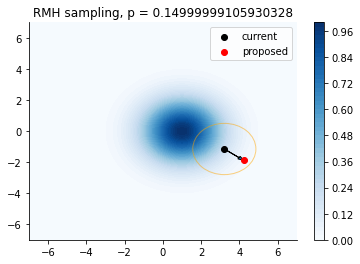

In [60]:
i = 121
x_cur = states.position[i-1,0,0]
y_cur = states.position[i-1,0,1]
x_prop = infos.proposal[0][i,0,0]
y_prop = infos.proposal[0][i,0,1]
fig, ax = plt.subplots(1, 1)
cs = ax.contourf(XX,YY,likel,50,cmap="Blues")
ax.scatter(x_cur,y_cur,c='black',label='current')
ell = Ellipse( (x_cur, y_cur ),
                2*1.65*sigma_rmh[0] , 2*1.65*sigma_rmh[1],
                fill = False ,alpha=0.5,color='orange')
ax.add_artist(ell)
dx = infos.proposal[0][i,0,0] - states.position[i-1,0,0] 
dy = infos.proposal[0][i,0,1] - states.position[i-1,0,1] 
plt.arrow(states.position[i-1,0,0],states.position[i-1,0,1],dx,dy,head_width=0.2,length_includes_head = True)
ax.scatter(infos.proposal[0][i,0,0],infos.proposal[0][i,0,1],c=color[bool(infos.is_accepted[i])],label= 'proposed')
# ax.scatter(infos.proposal[0][i,0,0],infos.proposal[0][i,0,1],c="orange",label= 'proposed')

# ax.scatter(states.position[:i-1,0,0],states.position[:i-1,0,1],s=3,alpha=0.5,label='accepted')
ax.legend()
sns.despine()
p = jnp.round(infos.acceptance_probability[i],2)
ax.set_title(f"RMH sampling, p = {p}")
fig.colorbar(cs,ax = ax)
plt.savefig("figures/"+str(i))
# plt.close(fig)

In [58]:
p = jnp.round(infos.acceptance_probability[i],2)
p

DeviceArray(0.28, dtype=float32)

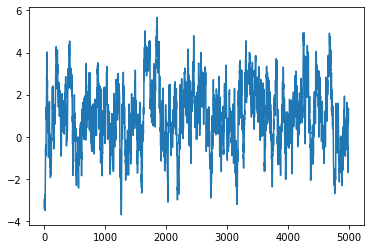

In [94]:
plt.plot(states.position[:,:,0].reshape(-1))

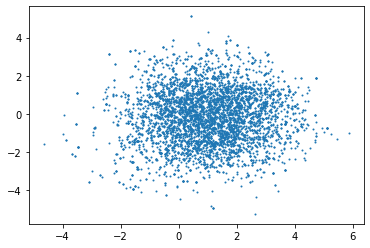

In [248]:
plt.scatter(states.position[:,:,0].reshape(-1),states.position[:,:,1].reshape(-1),s=1)

In [188]:
infos.proposal[0].shape

(500, 1, 2)

Further reading

Mathematical Monk -- https://www.youtube.com/watch?v=12eZWG0Z5gY